In [15]:
# 전처리 및 파생변수 생성
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로딩
df = pd.read_csv("sales_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# ✅ 날짜 기반 파생변수
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.day_name()
df['Is_Weekend'] = df['Weekday'].isin(['Saturday', 'Sunday']).astype(int)

# ✅ 수요 vs 판매량 차이 변수
df['Demand_Gap'] = df['Demand'] - df['Units Sold']

# ✅ 시차 변수 (제품별 전일 수요)
df = df.sort_values(by=['Product ID', 'Date'])
df['Prev_Day_Demand'] = df.groupby('Product ID')['Demand'].shift(1)
df['Rolling_7D_Demand'] = df.groupby('Product ID')['Demand'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# ✅ 범주형 변수 인코딩 (Label Encoding 예시)
cat_cols = ['Region', 'Category', 'Weather Condition', 'Seasonality', 'Weekday']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# ✅ 스케일링 (가격 관련 변수)
scaler = StandardScaler()
scaled_cols = ['Price', 'Competitor Pricing', 'Inventory Level']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

# ✅ 결측치 제거 (시차 변수 때문에 생긴 NaN)
df.dropna(inplace=True)

# ✅ 이상치 제거 함수 (IQR 기준)
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

original_shape = df.shape

# ✅ 주요 수치형 변수 이상치 제거
for col in ['Demand', 'Units Sold', 'Inventory Level']:
    df = remove_outliers_iqr(df, col)

after_shape = df.shape

print(f"📦 이상치 제거 전: {original_shape[0]} rows, {original_shape[1]} columns")
print(f"📦 이상치 제거 후: {after_shape[0]} rows, {after_shape[1]} columns")
print(f"➡️ 제거된 행 수: {original_shape[0] - after_shape[0]} rows")

📦 이상치 제거 전: 75980 rows, 22 columns
📦 이상치 제거 후: 71127 rows, 22 columns
➡️ 제거된 행 수: 4853 rows


모델 비교 결과:
                        MAE       RMSE        R2
LinearRegression  24.118539  30.405385  0.483376
RandomForest      16.355732  21.941051  0.730977
GradientBoosting  18.957434  24.430941  0.666455


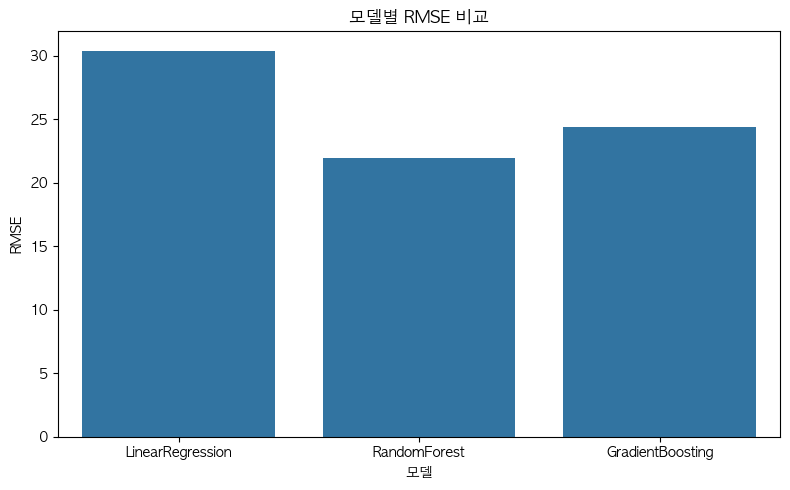

In [16]:
# 모델 비교

# 1. 사용할 한글 폰트 설정 (Apple 기본 'AppleGothic' 사용)
plt.rcParams['font.family'] = 'AppleGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로딩 및 날짜 처리
df_t = pd.read_csv("sales_data.csv")
df_t['Date'] = pd.to_datetime(df_t['Date'])

# 2. 파생 변수 생성
df_t['Month'] = df_t['Date'].dt.month
df_t['Weekday'] = df_t['Date'].dt.day_name()
df_t['Is_Weekend'] = df_t['Weekday'].isin(['Saturday', 'Sunday']).astype(int)
df_t['Demand_Gap'] = df_t['Demand'] - df_t['Units Sold']
df_t = df_t.sort_values(by=['Product ID', 'Date'])
df_t['Prev_Day_Demand'] = df_t.groupby('Product ID')['Demand'].shift(1)
df_t['Rolling_7D_Demand'] = df_t.groupby('Product ID')['Demand'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

# 3. 범주형 인코딩
label_cols = ['Region', 'Category', 'Weather Condition', 'Seasonality', 'Weekday']
for col in label_cols:
    df_t[col] = LabelEncoder().fit_transform(df_t[col])

# 4. 스케일링
scale_cols = ['Price', 'Competitor Pricing', 'Inventory Level']
df_t[scale_cols] = StandardScaler().fit_transform(df_t[scale_cols])

# 5. 이상치 제거 (IQR 기준)
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

for col in ['Demand', 'Units Sold', 'Inventory Level']:
    df_t = remove_outliers_iqr(df_t, col)

df_t.dropna(inplace=True)

# 6. 누설 가능성이 높은 변수 제거
X = df_t.drop(columns=[
    'Date', 'Store ID', 'Product ID', 'Demand',
    'Units Sold', 'Demand_Gap', 'Prev_Day_Demand'
])
y = df_t['Demand']

# 7. 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 8. 모델 초기화
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 9. 모델 학습 및 평가
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# 10. 결과 출력 및 시각화
results_df = pd.DataFrame(results).T
print("모델 비교 결과:")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y='RMSE', data=results_df.reset_index())
plt.title("모델별 RMSE 비교")
plt.ylabel("RMSE")
plt.xlabel("모델")
plt.tight_layout()
plt.show()



/var/folders/xr/6vq868n556x_y_02q2rbvdwm0000gn/T/ipykernel_9861/70983529.py:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/chaseunghyeon/AIteamprojet/mvenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


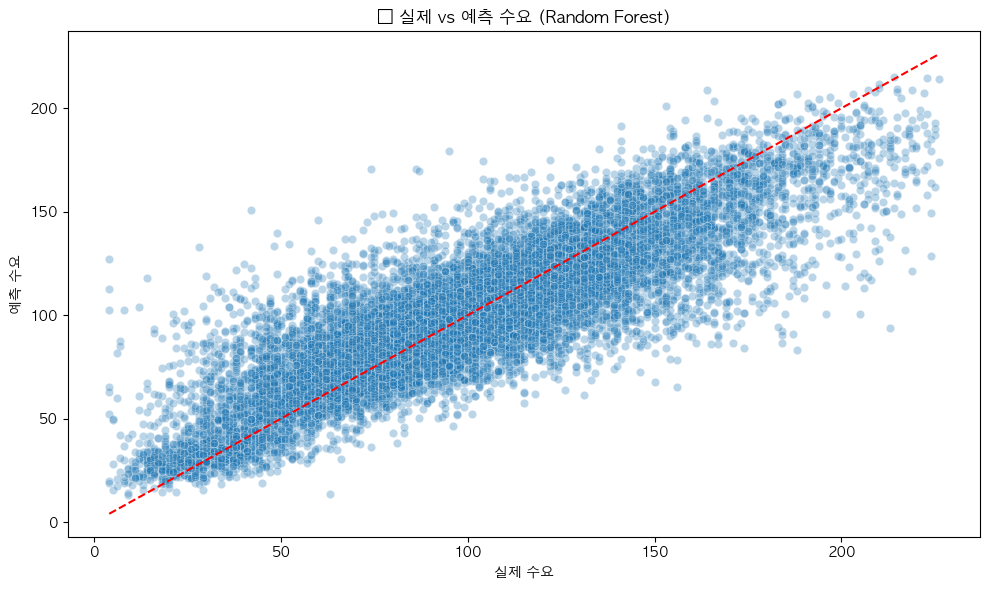


📊 Random Forest 성능 평가:
MAE: 16.36
RMSE: 21.94
R²: 0.7310


In [17]:
# 1. 사용할 한글 폰트 설정 (Apple 기본 'AppleGothic' 사용)
plt.rcParams['font.family'] = 'AppleGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# ✅ 입력/출력 정의
X = df.drop(columns=['Date', 'Store ID', 'Product ID', 'Demand','Units Sold', 'Demand_Gap', 'Prev_Day_Demand'])
y = df['Demand']

# ✅ 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ 예측 및 성능 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


# ✅ 예측 vs 실제 수요 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제 수요")
plt.ylabel("예측 수요")
plt.title("🔍 실제 vs 예측 수요 (Random Forest)")
plt.tight_layout()
plt.show()

print(f"\n📊 Random Forest 성능 평가:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


/var/folders/xr/6vq868n556x_y_02q2rbvdwm0000gn/T/ipykernel_9861/1508614913.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette=sns.color_palette("crest", as_cmap=False))
/var/folders/xr/6vq868n556x_y_02q2rbvdwm0000gn/T/ipykernel_9861/1508614913.py:12: UserWarning: 
The palette list has fewer values (6) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Importance', y='Feature', data=importance_df, palette=sns.color_palette("crest", as_cmap=False))
/var/folders/xr/6vq868n556x_y_02q2rbvdwm0000gn/T/ipykernel_9861/1508614913.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/chaseunghyeon/AIteamprojet/mvenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyp

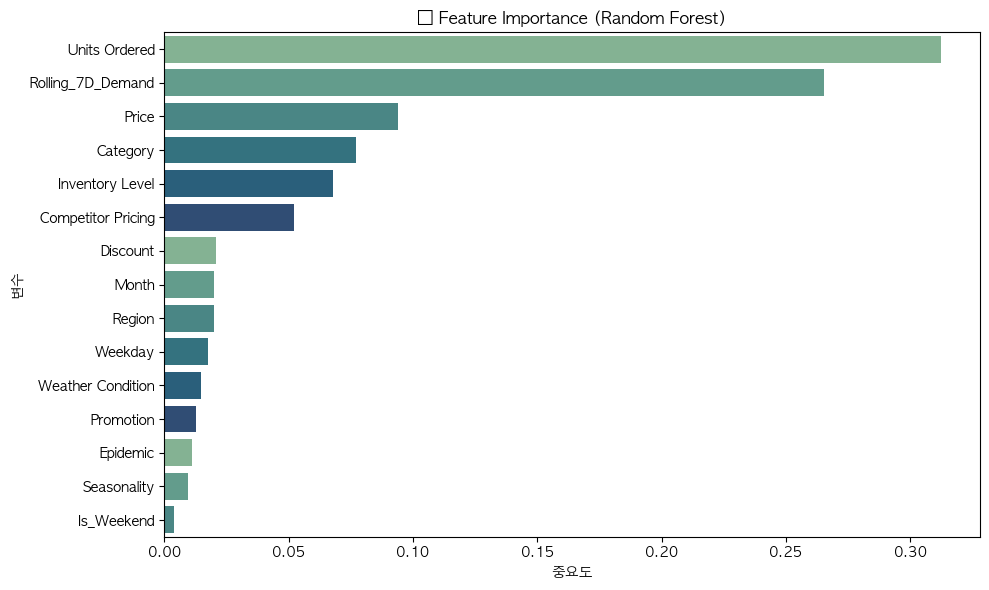


📌 상위 10개 중요 변수:
               Feature  Importance
3        Units Ordered    0.312379
14   Rolling_7D_Demand    0.265358
4                Price    0.094156
0             Category    0.077207
2      Inventory Level    0.067819
8   Competitor Pricing    0.051961
5             Discount    0.020790
11               Month    0.020149
1               Region    0.020145
12             Weekday    0.017766


In [18]:
# Feature Importance 추출 및 시각화
feature_importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette=sns.color_palette("crest", as_cmap=False))
plt.title("📊 Feature Importance (Random Forest)")
plt.xlabel("중요도")
plt.ylabel("변수")
plt.tight_layout()
plt.show()

# 상위 10개 출력
print("\n📌 상위 10개 중요 변수:")
print(importance_df.head(10))